In [1]:
#pip install wordcloud
#pip install textblob

# Importing packages
from bs4 import BeautifulSoup
import requests as rq
import pandas as pd
import re
import numpy as np
import urllib.parse
import tweepy
from unidecode import unidecode
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from tweepy import OAuthHandler
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob

# SDS BASECAMP FINAL EXAM
## Carolina Branas

## 1. Scraping www.thesoccerworldcups.com

### 1.1. World Cups Location and Year
Here, I am scraping a football statistics webpage.
First, I retrieve general information regarding the worldcups (WC):

In [2]:
og_url = 'https://www.thesoccerworldcups.com' # Main url from the webpage containing WC info
response = rq.get(og_url) # Using requests and obtaining a response
soup = BeautifulSoup(response.content, 'html.parser') # Using BeautifulSoup to work better with the data

html = list(soup.children)[2] # Accessing the content of the webpage that I am specifically interested in
response.ok # Just checking if the response is valid

True

In [3]:
world_cups = []
for div in html.find_all('div', class_='left w-50'): # Retrieving the place and year of celebration of each WC
    world_cups.append(div.text)

In [4]:
world_cup_df = [i.strip() for i in world_cups] # Removing leading and trailing white spaces from the WC list
world_cup_df.reverse() # Reversing the order so it fits into the df

Now, I retrieve the winner team for each World Cup:

In [5]:
winners = []
for div in html.find_all('div', class_='right w-50'): # Retrieving the place and year of celebration of each WC
    winners.append(div.text)

In [6]:
winners_df = [i.strip() for i in winners] # Removing leading and trailing white spaces from the WC list
winners_df.reverse()

### 1.2. Top Scorers and Names, Goals, Games, Goal Avg and Nationality

Now, I access the specific URL containing information regarding the world cups:

In [7]:
world_cups = '/world_cups.php' # Specific section of the webpage
response = rq.get(og_url + world_cups)
my_soup = BeautifulSoup(response.content, 'html.parser')

my_html = list(my_soup.children)[2] # Focusing on the main elements
my_html.find_all(class_='left margen-r5 margen-l5') # Finding the specific class containing the Top Scorers urls

[<div class="left margen-r5 margen-l5"><a href="world_cups/2022_results.php">Results</a>
 </div>,
 <div class="left margen-r5 margen-l5" style="min-width: 67px; min-height: 20px ;">
 <a href="world_cups/2022_playoffs.php">Playoffs</a>
 </div>,
 <div class="left margen-r5 margen-l5"><a href="world_cups/2022_top_scorers.php">Top Scorers</a>
 </div>,
 <div class="left margen-r5 margen-l5"><a href="world_cups/2022_final_standings.php">Final Standings</a>
 </div>,
 <div class="left margen-r5 margen-l5">
 <a href="world_cups/2022_awards.php">Awards</a>
 </div>,
 <div class="left margen-r5 margen-l5"><a href="world_cups/2018_results.php">Results</a>
 </div>,
 <div class="left margen-r5 margen-l5" style="min-width: 67px; min-height: 20px ;">
 <a href="world_cups/2018_playoffs.php">Playoffs</a>
 </div>,
 <div class="left margen-r5 margen-l5"><a href="world_cups/2018_top_scorers.php">Top Scorers</a>
 </div>,
 <div class="left margen-r5 margen-l5"><a href="world_cups/2018_final_standings.php">Fin

As I am interested in the statistics regarding the top scorers from each worldcup, I scrape the URLs inside the main page and create a list with the links of the 'Top Scorers' pages. I also clean the list a little bit:

In [8]:
scorers = [] # This list contains the urls I am interested in, but it needs to be cleaned up a little
for td in my_html.find_all('td'):
    scorers.append(str(td.find_all('a',text='Top Scorers'))) 
    
scorers_clean = []
for i in scorers:
    scorers_clean.append(re.findall(r'"(.*?)"', i)) # Retrieving the url

Finally, I remove empty spaces and I also flatten the list, so it is not a list of lists anymore:

In [9]:
all_scorers=[] # List without empty spaces
count=0
for url in scorers_clean:
    if count % 2 != 0:
        all_scorers.append(url)
    count += 1

In [10]:
flat_scorers = [i for sublist in all_scorers for i in sublist] # Flattening the list
# flat_scorers contains the urls to access info for each specific world cup, and will be used later

Now, I create a function that takes the website's html (all_soup) and looks for the top scorers' names in it. Then, the function stores these names in a list, which is returned:

*Note: This website https://www.zenrows.com/knowledge/scrape-from-a-list-of-urls#parallel helped a lot for this step*

In [11]:
def extract_name(data): # This function creates a list and stores the top scorers of each WC retrieved from the website
    all_scorers_list = [] # Creating a list
    all_scorers = data.find_all(class_ ='a-top') 
    for element in all_scorers:
        all_scorers_list.append(element.find('a').text) # Appending the names to the list
        return all_scorers_list # Returning the list

I do the same as before, but, instead of the top scorers' names, the following functions extract the amount of goals each player scored, as well as the games played:

In [12]:
def extract_goals(data): # This function creates a list and stores the goals scored retrieved from the website
    all_goals_list = [] # Creating a list
    all_goals = data.find_all(class_ ='a-top') 
    for element in all_goals:
        all_goals_list.append(element.find('b').text) # Appending the goals to the list
        return all_goals_list # Returning the list

In [13]:
def extract_games(data): # This function creates a list and stores the games played retrieved from the website
    games = [] # Creating a list with the games played
    tds_list = []
    for i in data.findAll('tr', {'class':'a-top'}): # Looping through td items in the html
        tds = i.findAll('td')
        tds_list.append(tds)
    for element in tds_list:
        games.append(element[3])
        return games

I also create a function for flattening lists, that will be useful in the future:

In [14]:
def flatten_lists(l):
    return list(np.concatenate(l).flat)

Now, I create lists that will store the information for the dataframe, and I iterate through the URLs retrieved before (each URL contains info from a specific WC) and I store the data in the lists, thanks to the functions created above:

In [15]:
url_start = 'https://www.thesoccerworldcups.com/'

names_df = []
goals_df = []
games_df = []

for url in flat_scorers:
    response = rq.get(url_start + url) 
    all_soup = BeautifulSoup(response.content, 'html.parser')
    names_df.append(extract_name(all_soup))
    goals_df.append(extract_goals(all_soup))
    games_df.append(extract_games(all_soup))

In the following lines I flatten all of the lists that I just created so the data looks good on the dataframe:

*Note: Info retrieved from https://stackabuse.com/python-how-to-flatten-list-of-lists/*

In [16]:
names_df = flatten_lists(names_df)
goals_df = flatten_lists(goals_df)
games_df = flatten_lists(games_df)

In [17]:
player_names_df = [item.strip() for item in names_df] # Removing spaces

### 1.3. Retrieving Bios from DuckDuckGo

Here, I am going to retrieve a short description for each of the players, retreived from DuckDuckGo:

In [18]:
url_start = 'https://api.duckduckgo.com/?q='
url_end = '&format=json&pretty=1'

descriptions = []
for i in names_df: 
    query = i
    ddg_response = rq.get(url_start + urllib.parse.quote(str(query)) + url_end)
    descriptions.append(ddg_response.json()) 
    
bios = []
for player in descriptions:
    if len(player['Abstract']) > 0: 
        bios.append(player['Abstract']) # Most bios are in the abstract container of the dictionary
    else:
        bios.append(np.nan) # Adding NaN values for unavailable bios

### 1.4. Specific Players Information (Birth Date, Position, Jersey Number, Birth Place, WC Champions or not and Dominant Foot)

The urlify function takes a list and gets the url inside each string. I will use this function to get the URLs containing each player individual info, like jersey number, birth date or position.

In [19]:
def urlify(li):
    urls = []
    for s in li:
        s = s.strip() # Remove leading spaces
        s = re.sub(r"[^\w\s]", '', s) # Remove all non-word characters (everything except numbers and letters)
        s = re.sub(r"\s+", '_', s) # Adding lower score instead of space
        s = s.lower() # All lower case
        s = unidecode(s) # Removing accents
        urls.append(s)
    return urls

Now I loop through the urls retrieved thanks to the urlify function, and I get a response that is turned into a soup. In the same loop, I store all the individual data from players in a list, players_info, that will be cleaned in the next steps:

In [20]:
players_info = []
for i in urlify(names_df):
    player = i 
    response_players = rq.get(og_url + '/players/' + player + '.php')
    players_soup = BeautifulSoup(response_players.content, 'html.parser')
    for j in players_soup.find_all('tr', class_='a-top'):
        players_info.append(j.text)
    

In the next cell, I am fixing the original list so it is easier to retrieve the information:

*Note: Wed_Week40_Notebook helped a lot for this task*

In [21]:
# Removing leading and trailing white spaces
players_info = [i.strip() for i in players_info]
# Remove list items without word characters or digits, incl. empty strings
players_info = [string for string in players_info if re.search('\w|\d',string)]
# Condense multiple spaces to one
players_info = [re.sub('\s+', ' ', string) for string in players_info]
# Convert one or more carriage returns to a single new line
players_info = [re.sub('\r+', '\n', string) for string in players_info]
# Convert multiple new line to a single new line
players_info = [re.sub('\n+', '\n', string) for string in players_info]
# Split up string at line breaks
players_info = [re.split('\n', string) for string in players_info]
# Flattening list
players_info = [i for sublist in players_info for i in sublist] 

In the following cell I create a function that splits the players_info list into sublists based on certain strings (in this case, I am interested in retrieving the date of birth, birthplace, position, jersey, website and Twitter account):

In [22]:
def split_by_substring (l, s1, s2, s3):
    sublist = [] 
    sublist_2 =[]
    sublist_3 =[]
    for element in l:
        if s1 in element:
            sublist.append(element)
        if s2 in element:
            sublist_2.append(element)
        if s3 in element:
            sublist_3.append(element)
        
    return sublist, sublist_2, sublist_3

In [23]:
born_date = split_by_substring(players_info, 'Born Date', 'Position', 'Jersey Number')[0]
position = split_by_substring(players_info, 'Born Date', 'Position', 'Jersey Number')[1]
jersey_number = split_by_substring(players_info, 'Born Date', 'Position', 'Jersey Number')[2]

In [24]:
jersey_df = []
for i in jersey_number:
    jersey_df.append(re.findall(r'\:(.*)', i))

born_date_df = []
for i in born_date:
    born_date_df.append(re.findall(r'\:(.*)', i))

position_df = []
for i in position:
    position_df.append(re.findall(r'\:(.*)', i))

In [25]:
# Flattening the lists
jersey_df = [i for sublist in jersey_df for i in sublist] 
born_date_df = [i for sublist in born_date_df for i in sublist]
position_df = [i for sublist in position_df for i in sublist]

# Removing white spaces
jersey_df = [i.strip() for i in jersey_df] # Removing leading and trailing white spaces
born_date_df = [i.strip() for i in born_date_df] # Removing leading and trailing white spaces
position_df = [i.strip() for i in position_df] # Removing leading and trailing white spaces

In [26]:
jersey_number_df = []
for i in jersey_df:
    if i == '-':
        jersey_number_df.append(np.nan)
    else:
        jersey_number_df.append(i)

Retrieving the brithplace of each top scorer:

In [27]:
birthplace = []
for i in urlify(names_df):
    player = i 
    response_birthplace = rq.get(og_url + '/players/' + player + '.php')
    birthplace_soup = BeautifulSoup(response_birthplace.content, 'html.parser')
    for j in birthplace_soup.find_all(class_='rd-100-30 a-center clearfix pad-t5 margen-b10'):
        birthplace.append(j.text)

In [28]:
birthplace = [i.strip() for i in birthplace] # Removing leading and trailing white spaces

birthplace_df = []
for i in birthplace:
    birthplace_df.append(re.sub(r'(''National Team\\n)', '',i))  # USE REGEX TO RETRIEVE USELESS TEXT

Here I create a list that shows if the top scorer's team also won the World Cup that specific year (0 = No, 1 = Yes):

In [29]:
champion_df = []
for i,j in zip(winners_df,birthplace_df):
    if i == j:
        champion_df.append(1) # The top scorer also won the World Cup that specific year
    else:
        champion_df.append(0) #  The top scorer didn't win the World Cup that specific year

Lastly, I want to store information about the dominant foot of each top scorer (0 = Right-footed, 1 = Left-footed). Unfortunately, this information was very hard to scrape online, so I built my own list based on previous research:

In [30]:
dominant_foot_df = [0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,1,0,1,0,0,1,1]

Here I am calculating the age each player had when he played the World Cup:

In [31]:
wc_year = []
for i in world_cup_df:
    wc_year.append(re.findall(r'\d{4}', i))

In [32]:
wc_year_df = [year for sublist in wc_year for year in sublist] # Flattening the list

In [33]:
birth_year = []
for i in born_date_df:
    birth_year.append(re.findall(r'\d{4}', i))

In [34]:
birth_year_df = [year for sublist in birth_year for year in sublist] # Flattening the list

In [35]:
wc_year_df = [int(i) for i in wc_year_df] # Turning the items of wc_year_df from str to int
birth_year_df = [int(i) for i in birth_year_df] # Turning the items of birth_year_df from str to int

In [36]:
age_in_wc = []

for i,j in zip(wc_year_df,birth_year_df):
    age_in_wc.append(i - j)

### 1.5. Building the Dataframe

Now, I am going to build a dataframe with all of the information retrieved from the webpage, but first, I have to turn the items of the lists from strings to ints, so the future visualizations are possible:

In [37]:
goals_df = [int(i) for i in goals_df] # Turning the items of goals_df from str to int
games_df = [int(i) for i in games_df] # Turning the items of games_df from str to int

In [38]:
g_avg = [x / y for x, y in zip(goals_df, games_df)] # Calculating the average goals / game

In [39]:
football_df = pd.DataFrame(list(zip(world_cup_df, winners_df, player_names_df, birthplace_df, jersey_number_df, born_date_df, age_in_wc, position_df, goals_df, games_df, g_avg, champion_df, dominant_foot_df, bios)), columns =['world_cup','winning_team','top_scorers','nationality','jersey','birth','age_at_world_cup','position','goals','games','goal_avg','winner','dominant_foot','bio'])
football_df

,world_cup,winning_team,top_scorers,nationality,jersey,birth,age_at_world_cup,position,goals,games,goal_avg,winner,dominant_foot,bio
0,2022 Qatar,Argentina,Kylian Mbappé,France,10,"December 20, 1998",24,Forward,8,7,1.142857,0,0,Kylian Mbappé Lottin is a French professional ...
1,2018 Russia,France,Harry Kane,England,9,"July 28, 1993",25,Forward,6,6,1.000000,0,0,NaN
2,2014 Brazil,Germany,James Rodríguez,Colombia,10,"July 12, 1991",23,Midfielder,6,5,1.200000,0,0,NaN
3,2010 South Africa,Spain,Diego Forlan,Uruguay,21 and 10,"May 19, 1979",31,Forward,5,7,0.714286,0,0,Diego Martín Forlán Corazo is a Uruguayan prof...
4,2006 Germany,Italy,Miroslav Klose,Germany,11,"June 09, 1978",28,Forward,5,7,0.714286,0,0,Miroslav Josef Klose is a German professional ...
5,2002 Korea / Japan,Brazil,Ronaldo,Brazil,20 and 9,"September 22, 1976",26,Forward,8,7,1.142857,1,0,NaN
6,1998 France,France,Davor Suker,YugoslaviaCroatia,20 and 9,"January 01, 1968",30,Forward,6,7,0.857143,0,1,Davor Šuker is a Croatian football administrat...
7,1994 USA,Brazil,Oleg Salenko,Russia,9,"October 25, 1969",25,Forward,6,3,2.000000,0,1,Oleg Anatolyevich Salenko is a Russian-Ukraini...
8,1990 Italy,Germany,Salvatore Schillaci,Italy,19,"December 01, 1964",26,Forward,6,7,0.857143,0,0,"Salvatore ""Totò"" Schillaci is an Italian forme..."
9,1986 Mexico,Argentina,Gary Lineker,England,10,"November 30, 1960",26,Forward,6,5,1.200000,0,1,Gary Winston Lineker is an English former prof...


Saving the dataframe as a csv file:

In [40]:
football_df.to_csv('football_df_branas.csv')

In the following cells, I inspect the dataframe and its columns:

In [41]:
football_df.columns

Index(['world_cup', 'winning_team', 'top_scorers', 'nationality', 'jersey',
       'birth', 'age_at_world_cup', 'position', 'goals', 'games', 'goal_avg',
       'winner', 'dominant_foot', 'bio'],
      dtype='object')

In [42]:
football_df.isna().sum() # Checking for NaN values

world_cup           0
winning_team        0
top_scorers         0
nationality         0
jersey              4
birth               0
age_at_world_cup    0
position            0
goals               0
games               0
goal_avg            0
winner              0
dominant_foot       0
bio                 7
dtype: int64

In [43]:
football_df.dtypes

world_cup            object
winning_team         object
top_scorers          object
nationality          object
jersey               object
birth                object
age_at_world_cup      int64
position             object
goals                 int64
games                 int64
goal_avg            float64
winner                int64
dominant_foot         int64
bio                  object
dtype: object

In [44]:
football_df.select_dtypes(include=np.number).columns.to_list() # Checking which columns contain numerical values

['age_at_world_cup', 'goals', 'games', 'goal_avg', 'winner', 'dominant_foot']

In [45]:
football_df['goal_avg'].describe()

count    22.000000
mean      1.314069
std       0.471942
min       0.714286
25%       0.892857
50%       1.200000
75%       1.625000
max       2.200000
Name: goal_avg, dtype: float64

In [46]:
football_df.groupby(['dominant_foot']).count()

,world_cup,winning_team,top_scorers,nationality,jersey,birth,age_at_world_cup,position,goals,games,goal_avg,winner,bio
dominant_foot,,,,,,,,,,,,,
0,14,14,14,14,12,14,14,14,14,14,14,14,8
1,8,8,8,8,6,8,8,8,8,8,8,8,7


In [47]:
# Top scorers from each nationality
football_df.groupby(['nationality']).count()['top_scorers']

nationality
Argentina            2
Brazil               3
Colombia             1
Czechoslovakia       1
England              2
France               2
Germany              1
Hungary              2
Italy                2
Poland               1
Portugal             1
Russia               1
Uruguay              1
West Germany         1
YugoslaviaCroatia    1
Name: top_scorers, dtype: int64

### 1.6. Plotting the Data Using MatplotLib

In [ ]:
x = football_df['goal_avg']

fig, axs = plt.subplots(nrows=2, ncols=2)
axs[0, 0].scatter(x, football_df['age_at_world_cup'])
axs[0, 0].set_title('1')

axs[0, 1].stem(x, football_df['nationality'])
axs[0, 1].set_title('2')

axs[1, 0].stem(x, football_df['position'])
axs[1, 0].set_title('3')


axs[1, 1].stem(x, football_df['dominant_foot'])
axs[1, 1].set_title('3')

fig.tight_layout()
plt.show()

In [49]:
plt.

In [50]:
#plt.hist(football_df[('Goals'), ('Age at the World Cup')])

### 1.7. Building Hypothesis 

Outcome = goal avg
Predictors = age and games

*Note: Useful link: https://www.statology.org/ols-regression-python/* 


In [51]:
est_model = ols('goal_avg~age_at_world_cup',data=football_df).fit()
est_model.params

Intercept           3.307678
age_at_world_cup   -0.078320
dtype: float64

## Ideas for the df: 
- Add other individual data like highest speed, km per game, etc. 
- Hector - try to retrieve all of the info in one function, taking advantage of the table structure of the original html

# 2. Twitter Data from BBCWorld

In [52]:
#conda install -c conda-forge tweepy

In [53]:
# SETUP GIVEN YOU HAVE CREATED AN AppCred FILE

# set up authentication for twitter
from AppCred import BEARER_TOKEN
from AppCred import CONSUMER_KEY, CONSUMER_SECRET
from AppCred import ACCESS_TOKEN, ACCESS_TOKEN_SECRET

client = tweepy.Client(bearer_token = BEARER_TOKEN,
                       consumer_key = CONSUMER_KEY,
                       consumer_secret = CONSUMER_SECRET,
                       access_token = ACCESS_TOKEN,
                       access_token_secret = ACCESS_TOKEN_SECRET,
                       return_type=dict,        # Return the response as a Python dictionary.
                       wait_on_rate_limit=True) # Wait once the rate limit is reached.

## Tweepy Methods (for my own clarification)
*Get Users*:
- .get_user(username or id) > data: id, name, username
- If you want more fields you need to specify in user fields: .get_user (username/id, user_field = [] > dictionary with specified fields

*Getting Tweets from a User:*
- .get_users_tweets(id)
- You can add extra parameters like: 
a) max results (to specify number of tweets)
b) until_id (to specify from where you want to start looking)
c) tweet_fields (extra fields you might need)

*Getting Tweets from a keyword/phrase:*
- .search_recent_tweets('phrase') > returns tweet id and text of tweet
- You can add more parameters: 
a) max results
b) tweet_fields


### 2.1. Accessing the BBCWorld Twitter Information

Firt of all, I use the .get_user method to retrieve some information of the BBCWorld account:

In [54]:
bbc = client.get_user(username = 'BBCWorld', user_fields = ['created_at', 'description', 'entities', 'id',
                                            'location', 'name', 'pinned_tweet_id', 
                                            'profile_image_url', 'protected', 'public_metrics',
                                            'url', 'username', 'verified', 'withheld'])

# This returns a dictionary with important info:
bbc

{'data': {'url': 'https://t.co/4zUWrLAYqP',
  'username': 'BBCWorld',
  'entities': {'url': {'urls': [{'start': 0,
      'end': 23,
      'url': 'https://t.co/4zUWrLAYqP',
      'expanded_url': 'http://www.bbc.com/news',
      'display_url': 'bbc.com/news'}]},
   'description': {'mentions': [{'start': 77,
      'end': 89,
      'username': 'BBCBreaking'},
     {'start': 100, 'end': 108, 'username': 'BBCNews'},
     {'start': 129, 'end': 138, 'username': 'BBCSport'}]}},
  'name': 'BBC News (World)',
  'protected': False,
  'profile_image_url': 'https://pbs.twimg.com/profile_images/1529107170448523264/q3VwEx38_normal.jpg',
  'created_at': '2007-02-01T07:44:29.000Z',
  'verified': True,
  'location': 'London, UK',
  'id': '742143',
  'public_metrics': {'followers_count': 39260459,
   'following_count': 18,
   'tweet_count': 356628,
   'listed_count': 133210},
  'description': "News, features and analysis from the World's newsroom. Breaking news, follow @BBCBreaking. UK news, @BBCNews. Lat

### 2.2. Retrieving Tweets

In the following cell, I create a variable containing the specific id of the account. I can use this id to retrieve, for example, some of the tweets that have been published:

In [ ]:
id_bbc = bbc['data']['id']

Now, I count the total amount of tweets published by the BBCWorld account. There are a total of 356392, too many, so I will retrieve only the first 300 tweets.

In [56]:
# Checking how many tweets have been published by this account
tweet_count = bbc['data']['public_metrics']['tweet_count']

With Tweepy, I can only retrieve a maximum of 100 tweets. On the other hand, by using max_results and until_id, it is possible to retreive chunks of 100 tweets:

In [57]:
tweets = []

for i in range(3):
    if i == 0:
        # Here, I access the first 100 tweets and store them in the previously created list
        tweets_100 = client.get_users_tweets(id_bbc, max_results = 100, tweet_fields = ['created_at', 'public_metrics'])
        tweets.extend(tweets_100['data'])
        last_id = tweets_100['data'][-1]['id'] # Access the ID of the last tweet in the list.
    
    else:
        tweets_100 = client.get_users_tweets(id_bbc, max_results = 100, until_id = last_id, tweet_fields = ['created_at', 'public_metrics'])
        tweets.extend(tweets_100['data'])
        last_id = tweets_100['data'][-1]['id']

Making a sentiment analysis of the tweets retrieved *(from https://medium.com/@jainmonil2101/scraping-tweets-with-python-to-build-a-sentiment-classifier-6ab06125c9ed)*:

In [58]:
def sentiment_of_tweets(tweet):
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

In [59]:
tweet_sentiments = []

for tweet in tweets:
    tweet_sentiments.append(sentiment_of_tweets(tweet['text']))

In [60]:
def get_sentiment_counts(sentiment_list):
    positive_count = 0
    negative_count = 0
    neutral_count = 0
    for sentiment in sentiment_list:
        if sentiment == 'positive':
            positive_count += 1
        elif sentiment == 'negative':
            negative_count += 1
        else:
            neutral_count += 1
    return [positive_count, negative_count, neutral_count]

### 2.3. Building the DataFrame 

*Got interesting info from: https://www.kirenz.com/post/2021-12-10-twitter-api-v2-tweepy-and-pandas-in-python/twitter-api-v2-tweepy-and-pandas-in-python/ and https://github.com/RodolfoFerro/pandas_twitter/blob/master/01-extracting-data.md*

*Check this, it is interesting: https://medium.com/codex/whose-tweet-was-it-originally-f746d4058e6f*

In [61]:
sentiment_count = get_sentiment_counts(tweet_sentiments)

In [62]:
# CAN ALSO BE DONE THIS WAY
tweets_data = tweets
df = pd.json_normalize(tweets_data)

In [63]:
df['sentiment'] = tweet_sentiments # Appending the sentiment of each tweet to the dataframe

In [64]:
df.columns

Index(['text', 'id', 'created_at', 'edit_history_tweet_ids',
       'public_metrics.retweet_count', 'public_metrics.reply_count',
       'public_metrics.like_count', 'public_metrics.quote_count', 'sentiment'],
      dtype='object')

In [65]:
df = df.drop('edit_history_tweet_ids', axis=1)

In [66]:
#df.rename({'a': 'X', 'b': 'Y'}, axis=1)  # new method
df2 = df.rename({'created_at':'created_at', 
                'public_metrics.retweet_count':'retweet_count',
                'public_metrics.favorite_count':'favorite_count',
                'public_metrics.reply_count':'reply_count',
                'public_metrics.like_count':'like_count',
                'public_metrics.quote_count':'quote_count'}, axis=1)

In [67]:
df2

,text,id,created_at,retweet_count,reply_count,like_count,quote_count,sentiment
0,Dramatic rescue after car plunges off Californ...,1610294430178615299,2023-01-03T15:18:04.000Z,16,11,86,1,negative
1,Snow shortage threatens Alps with wet winter s...,1610290898398576642,2023-01-03T15:04:02.000Z,27,15,93,6,negative
2,Black Eyed Peas in Polish row over rainbow arm...,1610285878294843394,2023-01-03T14:44:05.000Z,13,32,97,9,negative
3,Hunt for Mexico prison break escapees turns de...,1610283117050302467,2023-01-03T14:33:07.000Z,32,22,117,6,negative
4,Pele's coffin leaves Santos' stadium on a fire...,1610277676844998658,2023-01-03T14:11:30.000Z,58,11,344,2,neutral
...,...,...,...,...,...,...,...,...
295,South Korea sorry for not shooting down 'enemy...,1607682259129073664,2022-12-27T10:18:14.000Z,54,42,287,18,negative
296,Five ways the Ukraine war could go in 2023 htt...,1607675064706539520,2022-12-27T09:49:39.000Z,52,51,223,7,neutral
297,Taiwan extends mandatory military service to o...,1607668510817243139,2022-12-27T09:23:36.000Z,60,42,406,9,negative
298,Seven die in coach plunge horror in Spain http...,1607662027740168192,2022-12-27T08:57:50.000Z,34,7,168,1,neutral


In [68]:
# Remember to save the df as a csv file

### 2.4. Retrieving Account Information

I also retrieve info from the account itself by using the dictionary showed in 2.1.:

In [69]:
creation = bbc['data']['created_at'] # When was the acc created?

In [70]:
verified = bbc['data']['verified'] # Is the acc verified

In [71]:
name = bbc['data']['name'] # Name

In [72]:
location = bbc['data']['location'] # Location

In [73]:
username = bbc['data']['username'] # Username

Now I am retrieving the mentions and also their text: (This might be useless)

In [74]:
# Get tweets mentioning 'BBCWorld' with max_results set to 20.
bbc_mentions = client.search_recent_tweets(id_bbc, max_results = 100, tweet_fields = ['author_id','created_at'])

In [75]:
bbc_mentions['data'][2]['text'] # Just looking at things

'子どもの居場所、オンラインで広がる不登校支援の選択肢―家庭庁で具体策検討・政府  https://t.co/zPsDvuMN0j'

In [76]:
mentions_text = []
for i in bbc_mentions['data']:
    mentions_text.append(i['text'])

### 2.5. Analyzing Tweets and Counting Stop Words

I am going to analyze the tweets_text variable created before, which contains the last 300 tweets of the BBCWorld account. 

To do so, I am going to load the text file containing stop words provided to use during Week 40 for completing Exercise 10.

Then, I am going to apply some string methods to count which words have been more used within these 300 tweets. This will provide information about the most common news and trends throughout the last months.

#### Opening and fixing the stop words list:

In [77]:
# Opening the text file containing stop words
with open("stop_words copy.txt", "r") as txt: 
    stop_words = txt.read()

In [78]:
# Creating a list containing all the stop words
stop_words_list = stop_words.split('\n')

#### Creating a list containing the tweets' words

First, I extract only the text from each tweet retrieved before:

In [79]:
tweets_text = []
for tweet in tweets:
    tweets_text.append(tweet['text'])

In the following cells, I turn the text retrieved into a string, divide the string into words and turn each word into lower case:

In [80]:
text = str(tweets_text) # First, I turn the variable into a string so I can use string methods
text_lc = text.lower() # All words are now lower case
text_lc = text_lc.split() # Splitting the variable into words

Now, I remove non-word characters and also links and empty strings so I can later count the words more accurately:

In [81]:
# Removing non-word characters
text_words_only = [re.sub(r"\W", "", word) for word in text_lc]

In [82]:
# Removing links and empty strings too
no_links_text = [re.sub (r'(https|http)(\w*)', '', word) for word in text_words_only if re.sub(r'(https|http)(\w*)', "", word)] 

#### Finding only relevant words

Here I identify only the relevant words by using the previously imported 'stop_words copy.txt', and I count how often each word has been written in the tweets:

In [83]:
relevant_words = [word for word in no_links_text if word not in stop_words_list]

In [84]:
# DO THIS MYSELF INSTEAD OF COPYING AND PASTING

def word_freq(word_list):
    """Takes a list of words as input, returns a dictionary with words as keys and their frequency as values."""
    return {word:word_list.count(word) for word in word_list}

def sort_freq_dict(freq_dict):
    """Takes a word frequency dict as input, returns a dictionary sorted from highest to lowest value."""
    return dict(sorted(freq_dict.items(), key = lambda item: item[1], reverse = True))

In [85]:
frequency = word_freq(relevant_words)
sorted_frequency = sort_freq_dict(frequency)

In [86]:
sorted_frequency

{'ukraine': 20,
 'rt': 19,
 'says': 19,
 'new': 18,
 'year': 18,
 'man': 14,
 'bbcbreaking': 13,
 'pele': 13,
 'killed': 13,
 'australia': 12,
 'dies': 11,
 'covid': 11,
 'brazil': 10,
 'war': 10,
 'years': 10,
 'deadly': 9,
 'russia': 9,
 'aged': 9,
 '2023': 9,
 'police': 9,
 'world': 8,
 'pope': 8,
 'benedict': 8,
 'andrew': 8,
 'tate': 8,
 'chinese': 8,
 'president': 7,
 'accident': 7,
 '2022': 7,
 'died': 7,
 'arrested': 7,
 'indian': 7,
 'coffin': 6,
 'santos': 6,
 'player': 6,
 'british': 6,
 'helicopter': 6,
 'india': 6,
 'ban': 6,
 'woman': 6,
 'fireworks': 6,
 'uk': 6,
 'fell': 6,
 'influencer': 6,
 'china': 6,
 'russian': 6,
 'car': 5,
 'winter': 5,
 'nfl': 5,
 'field': 5,
 'attacks': 5,
 'crash': 5,
 'officials': 5,
 'death': 5,
 'say': 5,
 'attack': 5,
 'nn': 5,
 'people': 5,
 'xvi': 5,
 'dog': 5,
 'days': 5,
 'day': 5,
 'countries': 5,
 'ukrainian': 5,
 'video': 5,
 'storm': 5,
 'young': 5,
 'n': 5,
 'snow': 4,
 'game': 4,
 'suspended': 4,
 'collapses': 4,
 'record': 4,
 '

Generating wordcloud with the most mentioned words in the tweets:

*Note: Info retrieved from https://www.datacamp.com/tutorial/wordcloud-python*

In [87]:
relevant_words_str = str(relevant_words)

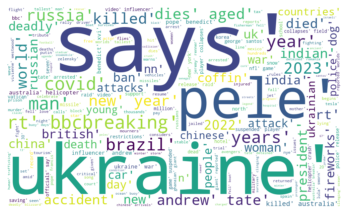

In [90]:
# Create and generate a word cloud image:
tweets_wordcloud = WordCloud(width=1000,height=600, background_color="white").generate(relevant_words_str)

# Display the generated image:
plt.imshow(tweets_wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()